In [ ]:
# IMPORTING NECESSARY LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping

**DATA COLLECTION**

In [ ]:
# Load the CSV file into a DataFrame
df = pd.read_csv('/content/uspollution_pollution_us_2000_2016.csv')

# Filter data for North Carolina
df_filtered = df[df['State'] == 'North Carolina'].copy()

# Read the filtered data for North Carolina from the CSV file
#df_filtered = pd.read_csv('/content/north_carolina_pollution.csv')
print(df_filtered.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37126 entries, 0 to 37125
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         37126 non-null  int64  
 1   State Code         37126 non-null  int64  
 2   County Code        37126 non-null  int64  
 3   Site Num           37126 non-null  int64  
 4   Address            37126 non-null  object 
 5   State              37126 non-null  object 
 6   County             37126 non-null  object 
 7   City               37126 non-null  object 
 8   Date Local         37126 non-null  object 
 9   NO2 Units          37126 non-null  object 
 10  NO2 Mean           37126 non-null  float64
 11  NO2 1st Max Value  37126 non-null  float64
 12  NO2 1st Max Hour   37126 non-null  int64  
 13  NO2 AQI            37126 non-null  int64  
 14  O3 Units           37126 non-null  object 
 15  O3 Mean            37126 non-null  float64
 16  O3 1st Max Value   371

**DATA CLEANING FOR RAW POLLUTANTS**

In [ ]:
# DROPPING THE UNNECESSARY COLUMNS FROM THE ORIGINAL DATA

columns_to_drop = ['Unnamed: 0','SO2 AQI', 'O3 AQI', 'NO2 AQI', 'CO AQI','Address']
df_filtered.drop(columns=columns_to_drop, inplace=True)

print("Unnecessary columns were dropped:")
print(columns_to_drop)

Unnecessary columns were dropped:
['Unnamed: 0', 'SO2 AQI', 'O3 AQI', 'NO2 AQI', 'CO AQI', 'Address']


**AQI CALCULATION**

In [ ]:
# Define the breakpoints for each pollutant according to the US EPA for annual averaging
# The breakpoints are defined as (concentration_low, concentration_high, AQI_low, AQI_high)
# Units for concentration are as follows:
# PM2.5 and PM10 in µg/m³ (micrograms per cubic meter)
# O3 in ppm (parts per million)
# CO in ppm (parts per million)
# SO2 and NO2 in ppb (parts per billion)

aqi_breakpoints = {
    'PM2.5': [(0.0, 12.0, 0, 50), (12.1, 35.4, 51, 100),
              (35.5, 55.4, 101, 150), (55.5, 150.4, 151, 200),
              (150.5, 250.4, 201, 300), (250.5, 350.4, 301, 400),
               (350.5, 500.4, 401, 500)],                       # µg/m³ (micrograms per cubic meter)

    'PM10': [(0, 54, 0, 50), (55, 154, 51, 100),
             (155, 254, 101, 150), (255, 354, 151, 200),
             (355, 424, 201, 300), (425, 504, 301, 400),
              (505, 604, 401, 500)],                            # µg/m³ (micrograms per cubic meter)

    'O3': [(0, 0.054, 0, 50), (0.055, 0.070, 51, 100),
           (0.071, 0.085, 101, 150), (0.086, 0.105, 151, 200),
           (0.106, 0.200, 201, 300)],                           # ppm (parts per million)

    'CO': [(0.0, 4.4, 0, 50), (4.5, 9.4, 51, 100),
           (9.5, 12.4, 101, 150), (12.5, 15.4, 151, 200),
            (15.5, 30.4, 201, 300), (30.5, 40.4, 301, 400),
            (40.5, 50.4, 401, 500)],                            # ppm (parts per million)

    'SO2': [(0.0, 35, 0, 50), (36, 75, 51, 100),
            (76, 185, 101, 150), (186, 304, 151, 200),
            (305, 604, 201, 300), (605, 804, 301, 400),
            (805, 1004, 401, 500)],                             # ppb (parts per billion) - Annual average

    'NO2': [(0.0, 53, 0, 50), (54, 100, 51, 100),
            (101, 360, 101, 150), (361, 649, 151, 200),
            (650, 1249, 201, 300), (1250, 1649, 301, 400),
            (1650, 2049, 401, 500)]                              # ppb (parts per billion) - Annual average
}


In [ ]:
# Function to calculate AQI for a given pollutant concentration using annual averaging breakpoints
def calculate_annual_aqi(concentration, aqi_breakpoints):
    for bp in aqi_breakpoints:
        C_low, C_high, I_low, I_high = bp
        if C_low <= concentration <= C_high:
            aqi = ((I_high - I_low) / (C_high - C_low)) * (concentration - C_low) + I_low
            return round(aqi)
    return None

In [ ]:
# Function to determine the level of concern based on AQI value
def determine_aqi_concern_level(aqi):
    if aqi is None:
        return "Unknown"
    elif 0 <= aqi <= 50:
        return "Good"
    elif 51 <= aqi <= 100:
        return "Moderate"
    elif 101 <= aqi <= 150:
        return "Unhealthy for Sensitive Groups"
    elif 151 <= aqi <= 200:
        return "Unhealthy"
    elif 201 <= aqi <= 300:
        return "Very Unhealthy"
    elif 301 <= aqi <= 500:
        return "Hazardous"
    else:
        return "Out of Range"

In [ ]:
# Rename columns to match pollutant names used in the code
column_mapping = {
    'SO2 1st Max Value': 'SO2',
    'O3 1st Max Value': 'O3',
    'NO2 1st Max Value': 'NO2',
    'CO 1st Max Value': 'CO'
}

df_filtered.rename(columns=column_mapping, inplace=True)

# Check the column names after renaming
print(df_filtered.columns)

Index(['State Code', 'County Code', 'Site Num', 'State', 'County', 'City',
       'Date Local', 'NO2 Units', 'NO2 Mean', 'NO2', 'NO2 1st Max Hour',
       'O3 Units', 'O3 Mean', 'O3', 'O3 1st Max Hour', 'SO2 Units', 'SO2 Mean',
       'SO2', 'SO2 1st Max Hour', 'CO Units', 'CO Mean', 'CO',
       'CO 1st Max Hour'],
      dtype='object')


In [ ]:
# Calculate AQI for each pollutant in the filtered DataFrame
for pollutant, bps in aqi_breakpoints.items():
    if pollutant in df_filtered.columns:
        aqi_column = f"{pollutant}_AQI"
        df_filtered[aqi_column] = df_filtered[pollutant].apply(lambda x: calculate_annual_aqi(x, bps))
    else:
        print(f"Skipping '{pollutant}' as it is not found in df_filtered columns.")

# List of pollutants to consider for overall AQI
pollutants_to_consider = [f"{pollutant}_AQI" for pollutant in column_mapping.values()]

# Calculate the overall AQI as the highest AQI among the specified pollutants
df_filtered['Overall_AQI'] = df_filtered[pollutants_to_consider].max(axis=1, skipna=True)

# Determine the overall level of concern based on the overall AQI
df_filtered['Level_of_Concern'] = df_filtered['Overall_AQI'].apply(determine_aqi_concern_level)

# Save the results back to a new CSV file including original data
df_filtered.to_csv('us-aqi-result.csv', index=False)

print("CSV file with AQI levels saved successfully.")

print(df_filtered.columns)

Skipping 'PM2.5' as it is not found in df_filtered columns.
Skipping 'PM10' as it is not found in df_filtered columns.
CSV file with AQI levels saved successfully.
Index(['State Code', 'County Code', 'Site Num', 'State', 'County', 'City',
       'Date Local', 'NO2 Units', 'NO2 Mean', 'NO2', 'NO2 1st Max Hour',
       'O3 Units', 'O3 Mean', 'O3', 'O3 1st Max Hour', 'SO2 Units', 'SO2 Mean',
       'SO2', 'SO2 1st Max Hour', 'CO Units', 'CO Mean', 'CO',
       'CO 1st Max Hour', 'O3_AQI', 'CO_AQI', 'SO2_AQI', 'NO2_AQI',
       'Overall_AQI', 'Level_of_Concern'],
      dtype='object')


**DATA CLEANING AFTER AQI PREDICTION**

In [ ]:
# Drop rows where all specified pollutant columns ('SO2', 'O3', 'NO2', 'CO') have no values
df_filtered.dropna(subset=['SO2', 'O3', 'NO2', 'CO'], how='all', inplace=True)

# Check for null values in the entire dataset
null_counts = df_filtered.isnull().sum()
total_nulls = null_counts.sum()

# Print counts of null values for each column and the total number of null values
print("Null Value Counts:")
print("====================")
print(null_counts)
print(f"Total null values in the dataset: {total_nulls}")

# Drop any remaining null values if they exist
if total_nulls > 0:
    df_filtered = df_filtered.dropna()
    print("Null values were present and have been dropped.")
    print(df_filtered.info())
else:
    print("No null values found. No rows were dropped.")

# Print the DataFrame info to confirm the changes and ensure it is clean
print(df_filtered.shape)

Null Value Counts:
State Code           0
County Code          0
Site Num             0
State                0
County               0
City                 0
Date Local           0
NO2 Units            0
NO2 Mean             0
NO2                  0
NO2 1st Max Hour     0
O3 Units             0
O3 Mean              0
O3                   0
O3 1st Max Hour      0
SO2 Units            0
SO2 Mean             0
SO2                  0
SO2 1st Max Hour     0
CO Units             0
CO Mean              0
CO                   0
CO 1st Max Hour      0
O3_AQI               0
CO_AQI               4
SO2_AQI             88
NO2_AQI              0
Overall_AQI          0
Level_of_Concern     0
dtype: int64
Total null values in the dataset: 92
Null values were present and have been dropped.
<class 'pandas.core.frame.DataFrame'>
Index: 37034 entries, 0 to 37125
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   State Code   

**DATA DESCRIPTION**

In [ ]:
# Display basic information about the dataset
print("df_filtered Dataset Information:")
print("====================")
print(df_filtered.info())

df_filtered Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 37034 entries, 0 to 37125
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   State Code        37034 non-null  int64  
 1   County Code       37034 non-null  int64  
 2   Site Num          37034 non-null  int64  
 3   State             37034 non-null  object 
 4   County            37034 non-null  object 
 5   City              37034 non-null  object 
 6   Date Local        37034 non-null  object 
 7   NO2 Units         37034 non-null  object 
 8   NO2 Mean          37034 non-null  float64
 9   NO2               37034 non-null  float64
 10  NO2 1st Max Hour  37034 non-null  int64  
 11  O3 Units          37034 non-null  object 
 12  O3 Mean           37034 non-null  float64
 13  O3                37034 non-null  float64
 14  O3 1st Max Hour   37034 non-null  int64  
 15  SO2 Units         37034 non-null  object 
 16  SO2 Mean    

In [ ]:
# Display summary statistics for numerical columns
print("\n DF Summary Statistics:")
print("====================")
print(df_filtered.describe())


 DF Summary Statistics:
       State Code   County Code      Site Num      NO2 Mean           NO2  \
count     37034.0  37034.000000  37034.000000  37034.000000  37034.000000   
mean         37.0    121.754874     37.691095     10.562726     23.839472   
std           0.0     22.023704      8.391833      5.630331     11.922436   
min          37.0     67.000000     14.000000      0.333333      0.500000   
25%          37.0    119.000000     41.000000      6.234783     14.000000   
50%          37.0    119.000000     41.000000      9.583333     23.000000   
75%          37.0    119.000000     41.000000     13.826087     32.000000   
max          37.0    183.000000     41.000000     38.708333     76.000000   

       NO2 1st Max Hour       O3 Mean            O3  O3 1st Max Hour  \
count      37034.000000  37034.000000  37034.000000     37034.000000   
mean          12.964951      0.029205      0.045641         9.963979   
std            8.193829      0.011307      0.016943         3.196

**EXPLORATORY DATA ANALYSIS**

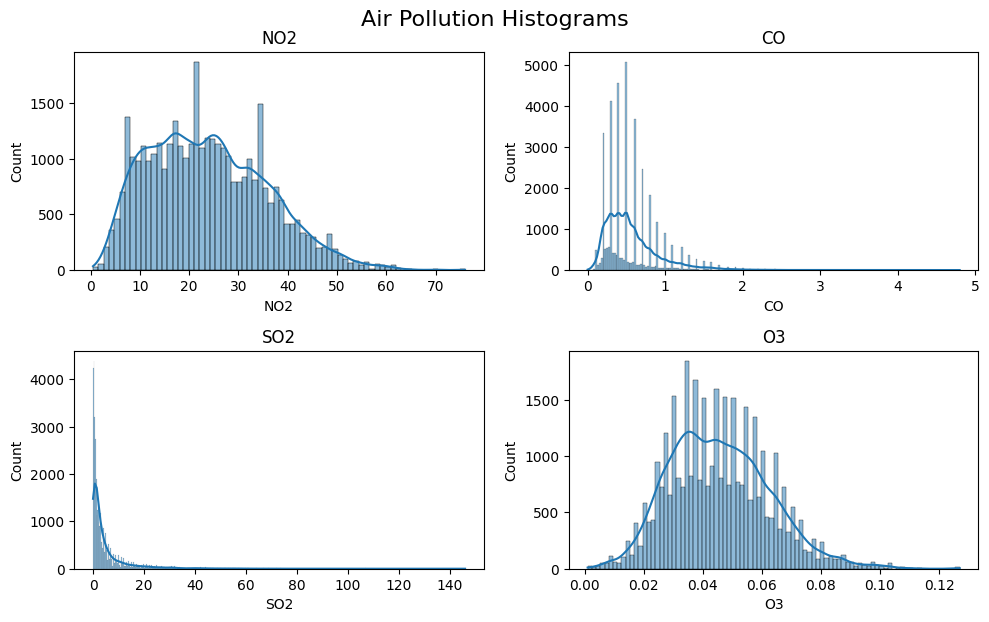

In [ ]:
# Define the specific continuous variables to plot
specific_continuous = ['NO2', 'CO', 'SO2', 'O3']

# Ensure that the specified variables exist in the DataFrame
specific_continuous = [var for var in specific_continuous if var in df_filtered.columns]

# Number of variables and desired number of rows and columns
num_vars = len(specific_continuous)
num_rows = 5  # Desired number of rows
num_cols = 2   # Desired number of columns

# Plot histograms for each specified continuous variable
fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 15))  # Adjust figsize to be smaller

# Flatten the axes array for easier iteration
ax = ax.flatten()

# Use a for loop to plot the histogram for each variable
for variable, subplot in zip(specific_continuous, ax):
    # Use histplot() to plot the histogram
    sns.histplot(df_filtered[variable], ax=subplot, kde=True)
    subplot.set_title(variable)

# Hide any unused subplots if fewer variables than subplots
for i in range(len(specific_continuous), len(ax)):
    fig.delaxes(ax[i])

# Add an overall title for the entire plot
plt.suptitle('Air Pollution Histograms', fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

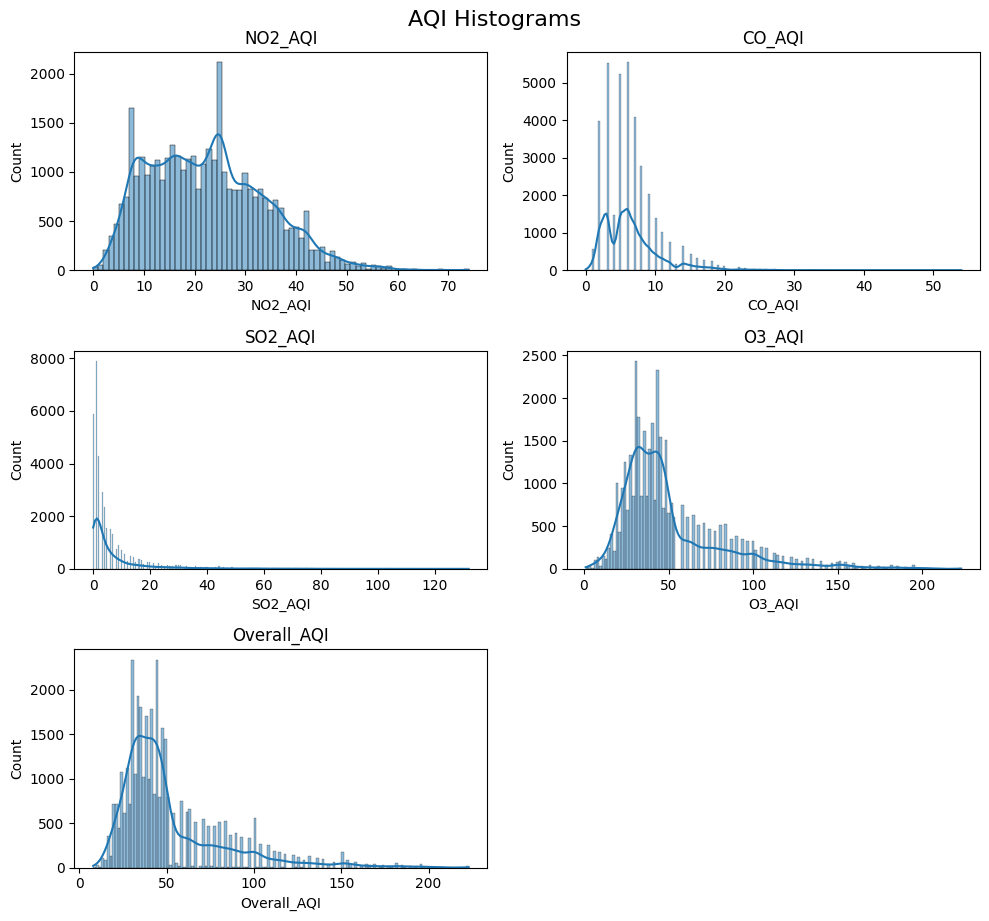

In [ ]:
# Define the specific continuous variables to plot
specific_continuous = ['NO2_AQI', 'CO_AQI', 'SO2_AQI', 'O3_AQI', 'Overall_AQI']

# Ensure that the specified variables exist in the DataFrame
specific_continuous = [var for var in specific_continuous if var in df_filtered.columns]

# Number of variables and desired number of rows and columns
num_vars = len(specific_continuous)
num_rows = 5  # Desired number of rows
num_cols = 2   # Desired number of columns

# Plot histograms for each specified continuous variable
fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 15))  # Adjust figsize to be smaller

# Flatten the axes array for easier iteration
ax = ax.flatten()

# Use a for loop to plot the histogram for each variable
for variable, subplot in zip(specific_continuous, ax):
    # Use histplot() to plot the histogram
    sns.histplot(df_filtered[variable], ax=subplot, kde=True)
    subplot.set_title(variable)

# Hide any unused subplots if fewer variables than subplots
for i in range(len(specific_continuous), len(ax)):
    fig.delaxes(ax[i])

# Add an overall title for the entire plot
plt.suptitle('AQI Histograms', fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()


['Good' 'Moderate' 'Unhealthy for Sensitive Groups' 'Very Unhealthy'
 'Unhealthy']


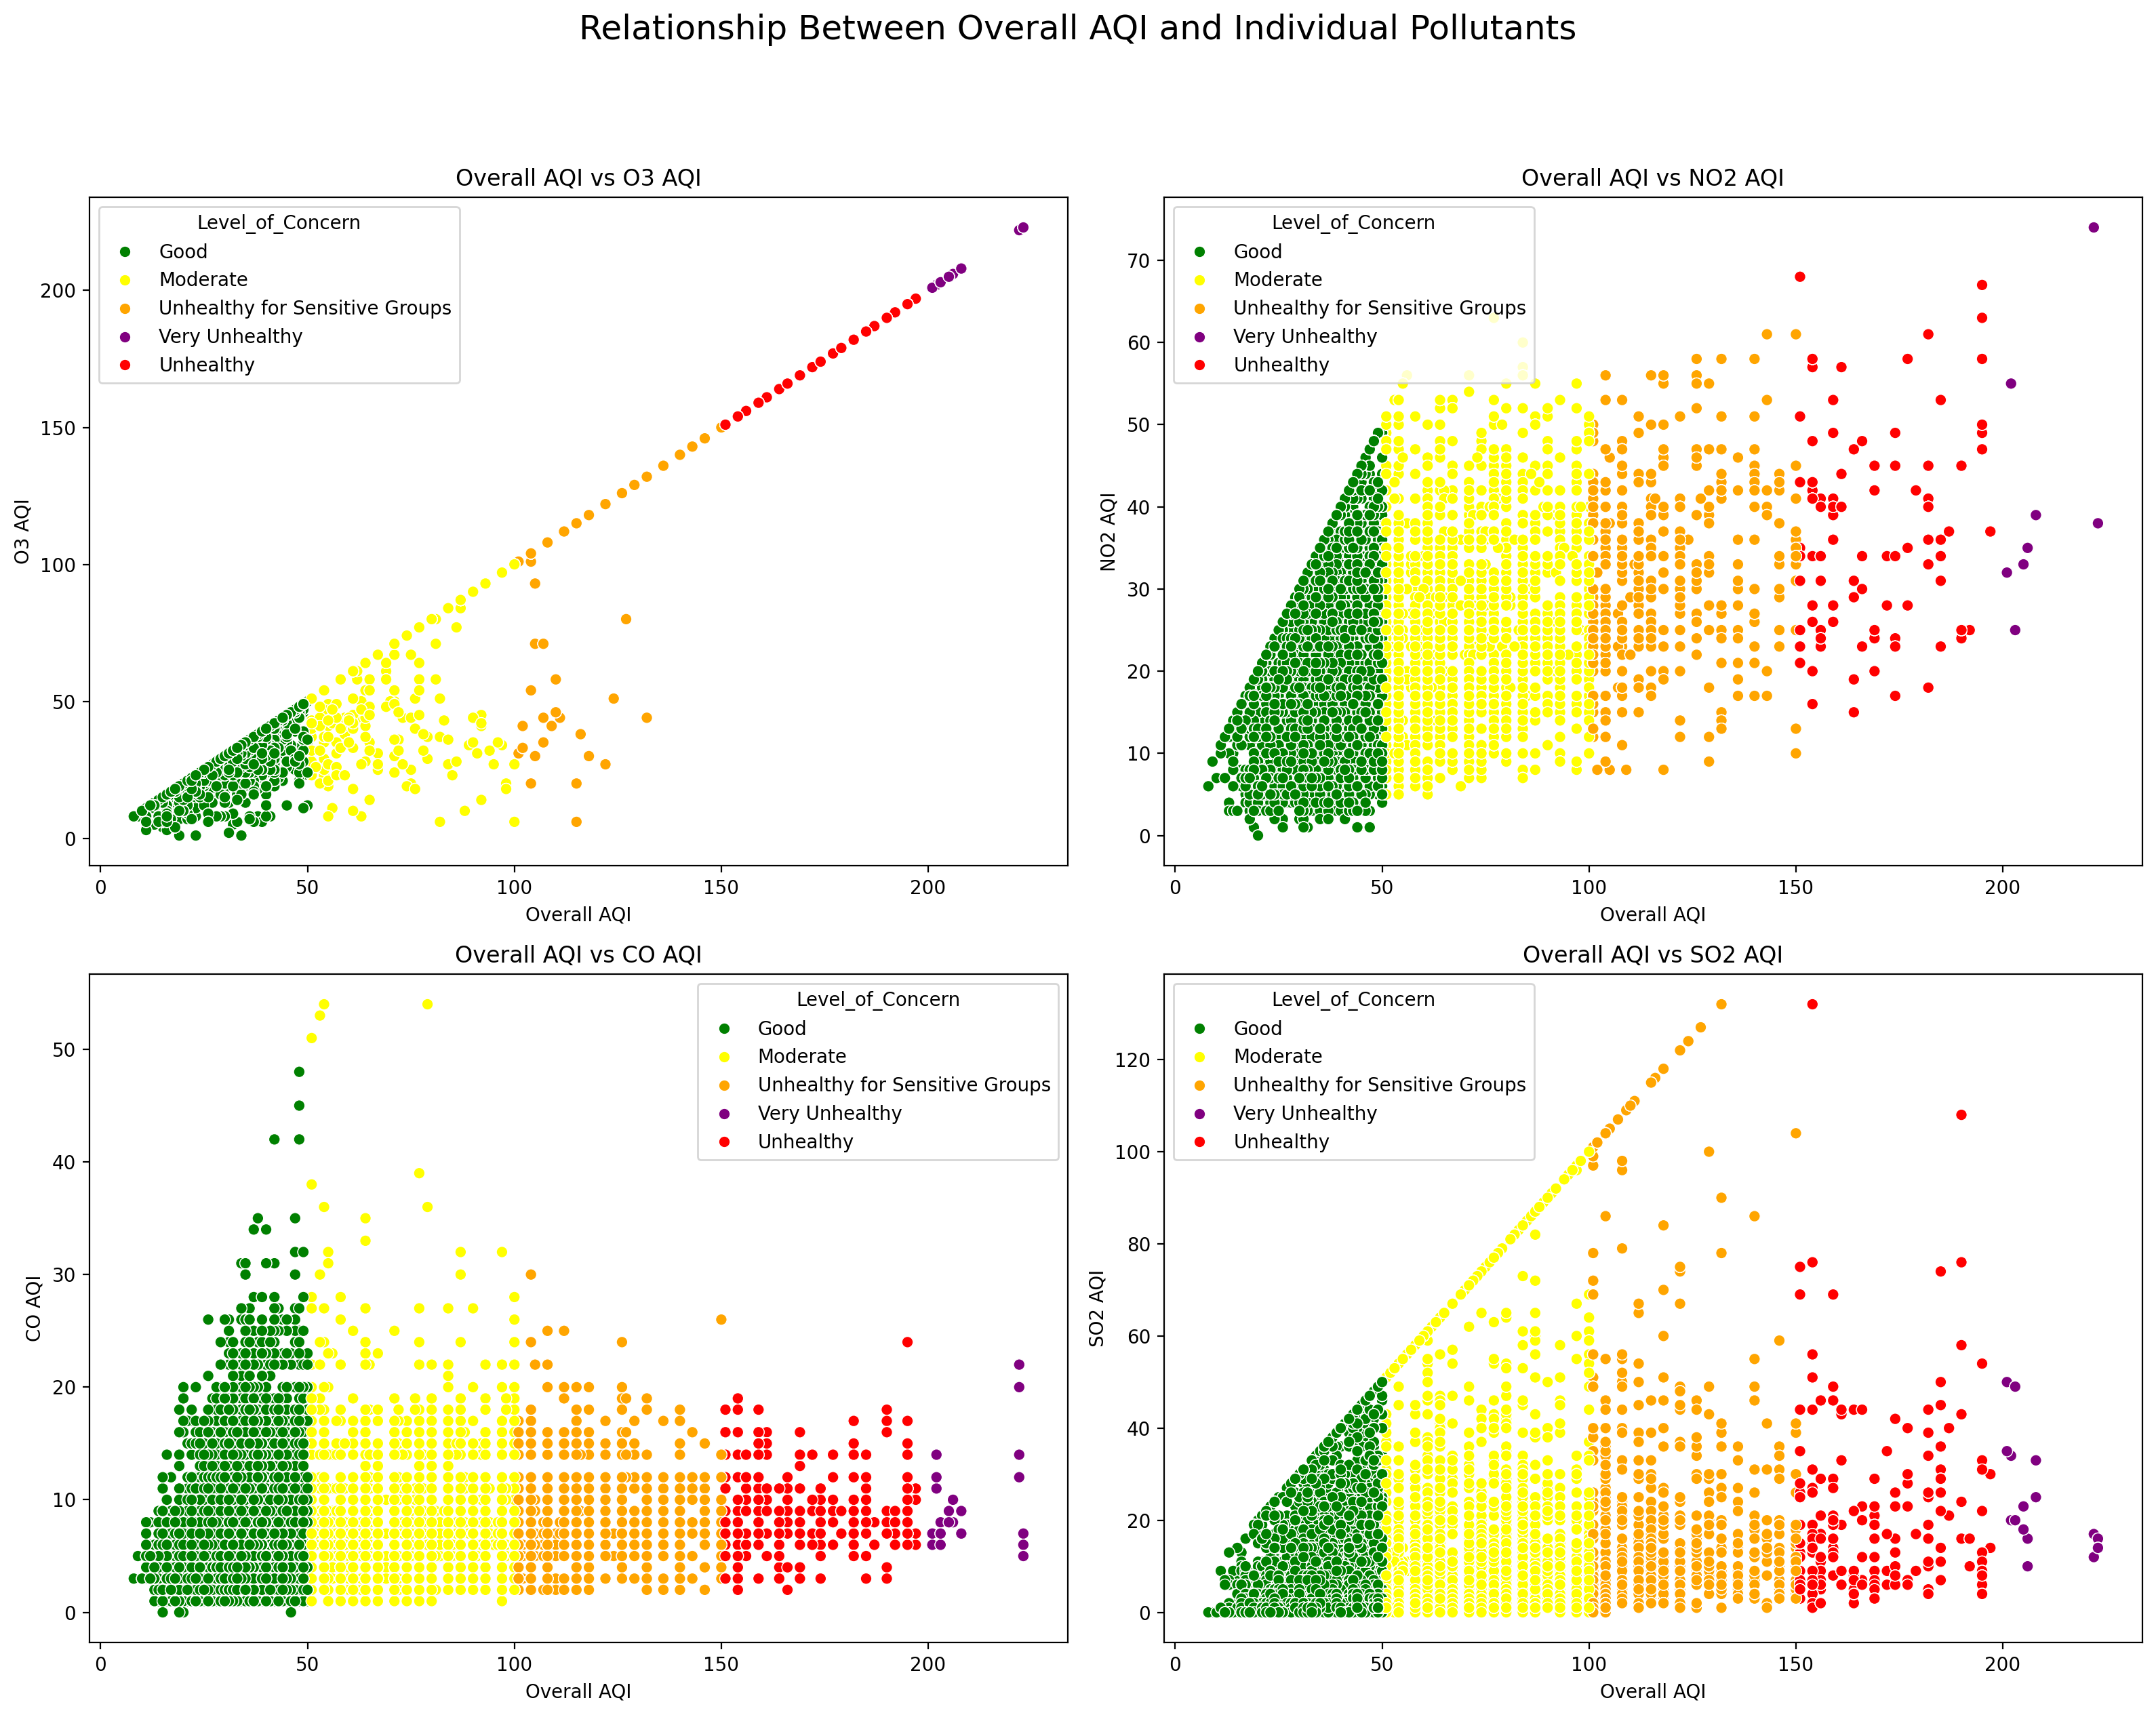

In [ ]:
# Print unique levels of concern
print(df_filtered['Level_of_Concern'].unique())

# Define palette with updated color mapping
palette = {
    'Good': "green",
    'Moderate': "yellow",
    'Unhealthy for Sensitive Groups': "orange",
    'Unhealthy': "red",
    'Very Unhealthy': "purple",
    'Hazardous': "maroon"
}

# Create a figure with 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12), dpi=200)

# Scatter plot 1: Overall AQI vs O3 AQI
sns.scatterplot(x='Overall_AQI', y='O3_AQI', data=df_filtered, hue='Level_of_Concern', palette=palette, ax=axs[0, 0])
axs[0, 0].set_xlabel('Overall AQI')
axs[0, 0].set_ylabel('O3 AQI')
axs[0, 0].set_title('Overall AQI vs O3 AQI')

# Scatter plot 2: Overall AQI vs NO2 AQI
sns.scatterplot(x='Overall_AQI', y='NO2_AQI', data=df_filtered, hue='Level_of_Concern', palette=palette, ax=axs[0, 1])
axs[0, 1].set_xlabel('Overall AQI')
axs[0, 1].set_ylabel('NO2 AQI')
axs[0, 1].set_title('Overall AQI vs NO2 AQI')

# Scatter plot 3: Overall AQI vs CO AQI
sns.scatterplot(x='Overall_AQI', y='CO_AQI', data=df_filtered, hue='Level_of_Concern', palette=palette, ax=axs[1, 0])
axs[1, 0].set_xlabel('Overall AQI')
axs[1, 0].set_ylabel('CO AQI')
axs[1, 0].set_title('Overall AQI vs CO AQI')

# Scatter plot 4: Overall AQI vs SO2 AQI
sns.scatterplot(x='Overall_AQI', y='SO2_AQI', data=df_filtered, hue='Level_of_Concern', palette=palette, ax=axs[1, 1])
axs[1, 1].set_xlabel('Overall AQI')
axs[1, 1].set_ylabel('SO2 AQI')
axs[1, 1].set_title('Overall AQI vs SO2 AQI')

# Add an overall title for the entire figure
plt.suptitle('Relationship Between Overall AQI and Individual Pollutants', fontsize=18, y=1.05)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

**ENCODING NON-NUMERIC TO NUMERIC**

In [ ]:
# Identify columns with non-numeric data types
non_numeric_columns = df_filtered.select_dtypes(include=['object']).columns
print("Non-Numeric Columns:")
print("====================")
print(non_numeric_columns)

# Initialize a dictionary to store LabelEncoders for each non-numeric column
label_encoders = {}

# Encode non-numeric columns into numeric values
for col in non_numeric_columns:
    le = LabelEncoder()
    df_filtered[col] = le.fit_transform(df_filtered[col])
    label_encoders[col] = le  # Store the LabelEncoder instance for possible future use

# Output the data types of columns after encoding to verify changes
print("Data types after label encoding:")
print(df_filtered.dtypes)

# Display the first few rows of the DataFrame to review the encoded values
print(df_filtered.head())

Non-Numeric Columns:
Index(['State', 'County', 'City', 'Date Local', 'NO2 Units', 'O3 Units',
       'SO2 Units', 'CO Units', 'Level_of_Concern'],
      dtype='object')
Data types after label encoding:
State Code            int64
County Code           int64
Site Num              int64
State                 int64
County                int64
City                  int64
Date Local            int64
NO2 Units             int64
NO2 Mean            float64
NO2                 float64
NO2 1st Max Hour      int64
O3 Units              int64
O3 Mean             float64
O3                  float64
O3 1st Max Hour       int64
SO2 Units             int64
SO2 Mean            float64
SO2                 float64
SO2 1st Max Hour      int64
CO Units              int64
CO Mean             float64
CO                  float64
CO 1st Max Hour       int64
O3_AQI                int64
CO_AQI              float64
SO2_AQI             float64
NO2_AQI               int64
Overall_AQI         float64
Level_of_Conce

**Select Features and Target Variable**

In [ ]:
#Select features (X) and target (y)
X = df_filtered.drop(columns=['Overall_AQI'])  # Features
y = df_filtered['Overall_AQI']  # Target variable

In [ ]:
# Print shapes of the resulting matrices
print("\nShapes of the matrices:")
print(f"X_shape: {X.shape}")
print(f"y_shape: {y.shape}")


Shapes of the matrices:
X_shape: (37034, 28)
y_shape: (37034,)


**STANDARDIZE THE FEATURE DATA**

In [ ]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Apply the scaler to the feature data (X) and transform it
X_scaled = scaler.fit_transform(X)

# Convert the scaled features back to a DataFrame
# Using the original feature names from the DataFrame X
df_scaled_features = pd.DataFrame(data=X_scaled, columns=X.columns)

# Display the first 10 rows of the scaled feature DataFrame
df_scaled_features.head(10)

,State Code,County Code,Site Num,State,County,City,Date Local,NO2 Units,NO2 Mean,NO2,...,SO2 1st Max Hour,CO Units,CO Mean,CO,CO 1st Max Hour,O3_AQI,CO_AQI,SO2_AQI,NO2_AQI,Level_of_Concern
0,0.0,-2.486213,-1.869831,0.0,-2.791588,3.554802,-1.691769,0.0,-0.132240,-0.657548,...,-1.683040,0.0,0.496866,0.379468,1.103664,-0.610863,0.382421,-0.493951,-0.663591,-0.550259
1,0.0,-2.486213,-1.869831,0.0,-2.791588,3.554802,-1.691769,0.0,-0.132240,-0.657548,...,-1.683040,0.0,0.228844,0.099256,1.437424,-0.610863,0.136807,-0.493951,-0.663591,-0.550259
2,0.0,-2.486213,-1.869831,0.0,-2.791588,3.554802,-1.691769,0.0,-0.132240,-0.657548,...,-1.361748,0.0,0.496866,0.379468,1.103664,-0.610863,0.382421,-0.493951,-0.663591,-0.550259
3,0.0,-2.486213,-1.869831,0.0,-2.791588,3.554802,-1.691769,0.0,-0.132240,-0.657548,...,-1.361748,0.0,0.228844,0.099256,1.437424,-0.610863,0.136807,-0.493951,-0.663591,-0.550259
4,0.0,-2.486213,-1.869831,0.0,-2.791588,3.554802,-1.691038,0.0,-0.366365,-0.405918,...,1.208581,0.0,0.961574,0.379468,-0.231378,-0.155653,0.382421,-0.493951,-0.397775,-0.550259
5,0.0,-2.486213,-1.869831,0.0,-2.791588,3.554802,-1.691038,0.0,-0.366365,-0.405918,...,1.208581,0.0,0.955459,0.099256,-1.010152,-0.155653,0.136807,-0.493951,-0.397775,-0.550259
6,0.0,-2.486213,-1.869831,0.0,-2.791588,3.554802,-1.691038,0.0,-0.366365,-0.405918,...,1.529872,0.0,0.961574,0.379468,-0.231378,-0.155653,0.382421,-0.571105,-0.397775,-0.550259
7,0.0,-2.486213,-1.869831,0.0,-2.791588,3.554802,-1.691038,0.0,-0.366365,-0.405918,...,1.529872,0.0,0.955459,0.099256,-1.010152,-0.155653,0.136807,-0.571105,-0.397775,-0.550259
8,0.0,-2.486213,-1.869831,0.0,-2.791588,3.554802,-1.690308,0.0,-0.499574,-0.573672,...,-1.683040,0.0,0.790365,0.379468,1.103664,-0.578348,0.382421,-0.571105,-0.574985,-0.550259
9,0.0,-2.486213,-1.869831,0.0,-2.791588,3.554802,-1.690308,0.0,-0.499574,-0.573672,...,-1.683040,0.0,0.932018,0.099256,-1.010152,-0.578348,0.136807,-0.571105,-0.574985,-0.550259


**PCA - FEATURE SELECTION**

In [ ]:
# Initialize the PCA model
pca = PCA()

# Fit the PCA model to the scaled feature data
pca.fit(df_scaled_features)

# Create a DataFrame for the loadings matrix
# Each row corresponds to a feature and each column to a principal component
loadings = pd.DataFrame(
    pca.components_.T,  # Transpose of the components matrix to align features with PCs
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],  # Principal component names
    index=df_scaled_features.columns  # Feature names
)

# Print the loadings matrix to view the relationship between features and principal components
print(loadings)


                           PC1           PC2           PC3           PC4  \
State Code        2.739220e-20  1.216169e-19 -6.853470e-19  7.300687e-19   
County Code      -1.755656e-01  7.437289e-02  4.930538e-01  1.162194e-01   
Site Num          9.139670e-02  4.126866e-02 -3.908007e-01 -4.387179e-01   
State             0.000000e+00  5.551115e-17  6.938894e-17  8.326673e-17   
County           -1.739267e-01  8.198493e-02  4.745230e-01  7.585810e-02   
City             -2.044242e-03 -8.972808e-02  1.576536e-01  4.297295e-01   
Date Local       -2.620067e-01  7.220542e-02  2.127206e-01 -3.810457e-02   
NO2 Units         0.000000e+00  0.000000e+00  0.000000e+00 -2.775558e-17   
NO2 Mean          3.037890e-01  2.273024e-01  7.145672e-02 -7.787607e-02   
NO2               3.138814e-01  1.590700e-01  1.439634e-01 -1.258985e-01   
NO2 1st Max Hour  2.329979e-02  1.479273e-01  5.715146e-02  4.980189e-02   
O3 Units          0.000000e+00  0.000000e+00  0.000000e+00 -0.000000e+00   
O3 Mean     

In [ ]:
# Compute the absolute sum of loadings for each feature across all principal components
# and sort them in descending order to identify the most contributing features

cumulative_contributions = loadings.abs().sum(axis=1).sort_values(ascending=False)

# Define the top features based on cumulative contributions
# Here we select all features but you can adjust to select a specific number (e.g., top 10)
top_features = cumulative_contributions.index[:]  # Example: Adjust to select top N features

# Print the cumulative contributions of all features
print("Cumulative Contributions of Features:")
print(cumulative_contributions)

# Print the selected top features
print("\nSelected Top Features Based on Cumulative Contribution:")
print(top_features)

Cumulative Contributions of Features:
CO                  3.090666
CO Mean             3.069153
CO_AQI              3.053303
NO2_AQI             3.043545
NO2                 3.033300
SO2                 3.002592
Level_of_Concern    2.977565
SO2_AQI             2.974796
O3_AQI              2.941031
NO2 Mean            2.935343
County              2.865827
O3 Mean             2.837065
SO2 Mean            2.787480
O3                  2.781482
CO 1st Max Hour     2.754055
Site Num            2.723352
City                2.705368
Date Local          2.658901
NO2 1st Max Hour    2.651601
County Code         2.628729
SO2 1st Max Hour    2.008144
O3 1st Max Hour     1.968055
NO2 Units           1.922254
O3 Units            1.798097
State               1.746021
SO2 Units           1.615805
CO Units            1.209388
State Code          1.002254
dtype: float64

Selected Top Features Based on Cumulative Contribution:
Index(['CO', 'CO Mean', 'CO_AQI', 'NO2_AQI', 'NO2', 'SO2', 'Level_of_Concern',

In [ ]:
# Define a threshold for selecting top features
threshold = 2.75  #Change the threshold for selecting number of features

# Identify the top features that meet or exceed the threshold
top_features = cumulative_contributions[cumulative_contributions >= threshold].index

# Display the selected top features
print("\nSelected top features based on threshold:")
print(top_features)

# Extract the columns corresponding to the selected top features from the dataset
X_top_features = df_filtered[top_features]

# Print the shape of the dataset with top features
print(X_top_features.shape)


Selected top features based on threshold:
Index(['CO', 'CO Mean', 'CO_AQI', 'NO2_AQI', 'NO2', 'SO2', 'Level_of_Concern',
       'SO2_AQI', 'O3_AQI', 'NO2 Mean', 'County', 'O3 Mean', 'SO2 Mean', 'O3',
       'CO 1st Max Hour'],
      dtype='object')
(37034, 15)


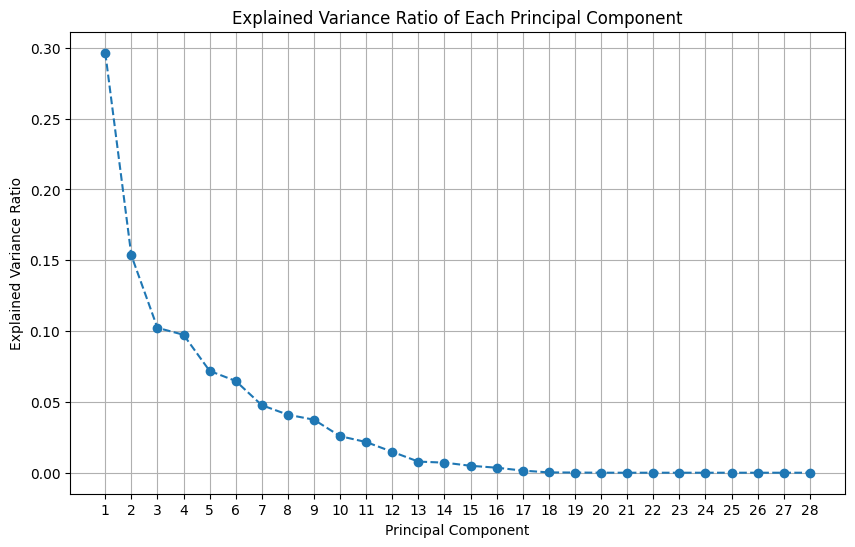

In [ ]:
# Get the explained variance ratios
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.title('Explained Variance Ratio of Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(np.arange(1, len(explained_variance_ratio) + 1))
plt.grid(True)
plt.show()


#LSTM

In [ ]:
# Assume y is already defined and converted to a numpy array
y = np.array(y)

# Scale the target data
target_scaler = MinMaxScaler()
scaled_target = target_scaler.fit_transform(y.reshape(-1, 1))

# Use the selected top features as the scaled features
scaled_features = X_top_features.values

# Print the shapes of the scaled features and target
print("\nShapes of the scaled matrices:")
print(f"scaled_features_shape: {scaled_features.shape}")
print(f"scaled_target_shape: {scaled_target.shape}")


Shapes of the scaled matrices:
scaled_features_shape: (37034, 15)
scaled_target_shape: (37034, 1)


In [ ]:
def create_sequences(data, target, seq_length):
    X, y = [], []
    num_samples = len(data) - seq_length
    for i in range(num_samples):
        X.append(data[i:i + seq_length])
        y.append(target[i + seq_length])
    return np.array(X), np.array(y)

In [ ]:
SEQ_LENGTH = 10  # Number of time steps to look back

# Check lengths before creating sequences
print(f"Length of scaled_features: {scaled_features.shape[0]}")
print(f"Length of scaled_target: {scaled_target.shape[0]}")

# Create sequences
X, y = create_sequences(scaled_features, scaled_target, SEQ_LENGTH)

Length of scaled_features: 37034
Length of scaled_target: 37034


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])
# Compile the model
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    epochs=100,  # Set a high number; early stopping will likely halt training before reaching this
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/100
810/810 [==============================] - 12s 11ms/step - loss: 0.0042 - val_loss: 0.0032
Epoch 2/100
810/810 [==============================] - 8s 10ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 3/100
810/810 [==============================] - 9s 11ms/step - loss: 0.0023 - val_loss: 0.0042
Epoch 4/100
810/810 [==============================] - 9s 11ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 5/100
810/810 [==============================] - 8s 10ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 6/100
810/810 [==============================] - 8s 10ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 7/100
810/810 [==============================] - 9s 11ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 8/100
810/810 [==============================] - 8s 10ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 9/100
810/810 [==============================] - 9s 11ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 10/100
810/810 [==============================] - 9s 11ms/step - loss: 0.00

In [ ]:
# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Check the number of epochs actually trained
print(f'Number of epochs trained: {len(history.history["loss"])}')

348/348 [==============================] - 1s 4ms/step - loss: 0.0020
Test Loss: 0.0020281909964978695
Number of epochs trained: 52


810/810 [==============================] - 3s 4ms/step


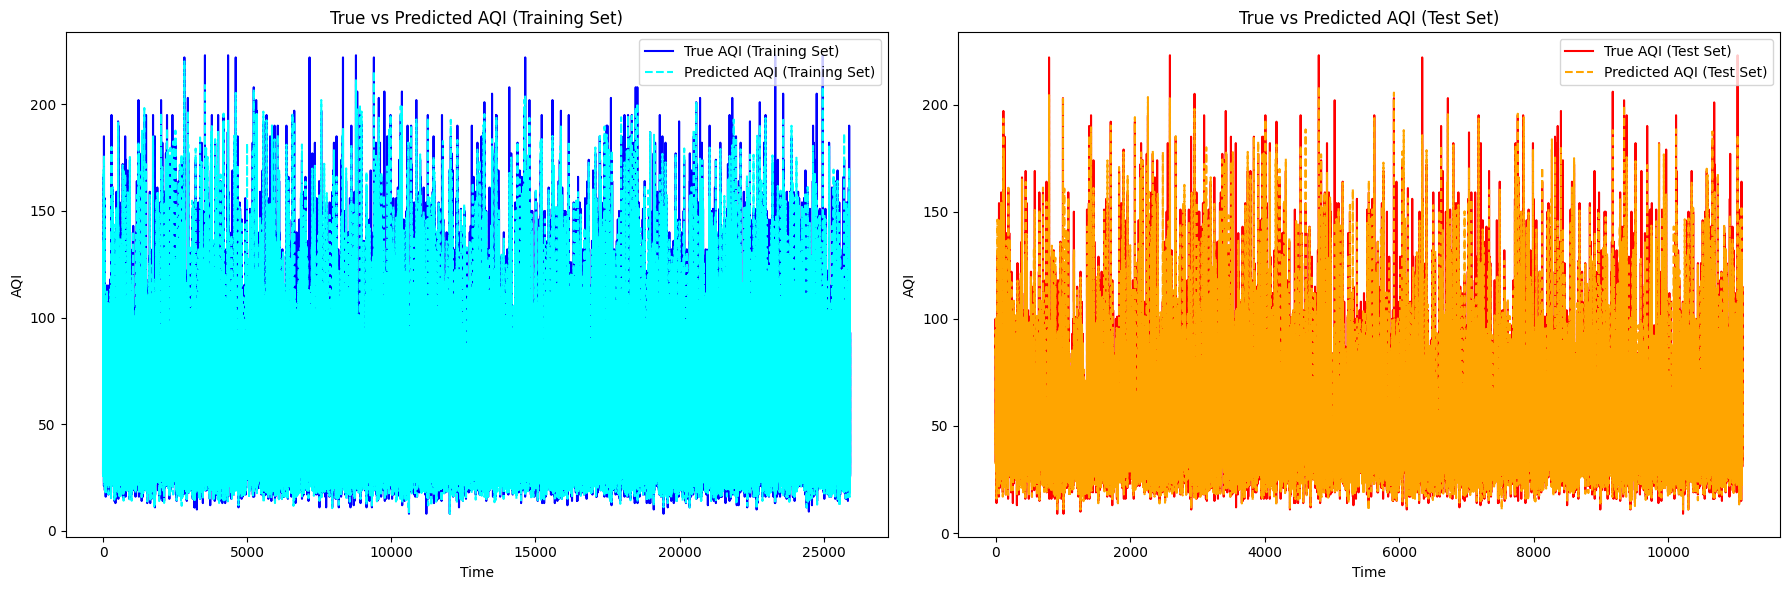

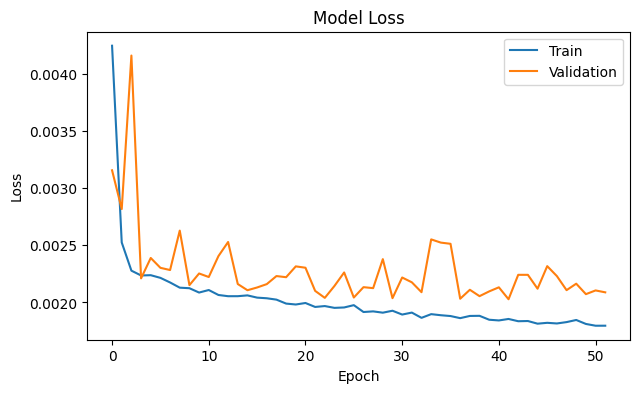

In [ ]:
# Make predictions
y_pred = model.predict(X_test)

# Inverse transform to original scale
y_test_rescaled = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_rescaled = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Assuming you have a similar scaler for training data (e.g., target_scaler)
y_train_pred = model.predict(X_train)
y_train_rescaled = target_scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_train_pred_rescaled = target_scaler.inverse_transform(y_train_pred.reshape(-1, 1)).flatten()
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot results for Training Set on the first subplot
ax1.plot(y_train_rescaled, label='True AQI (Training Set)', color='blue')
ax1.plot(y_train_pred_rescaled, label='Predicted AQI (Training Set)', linestyle='--', color='cyan')
ax1.set_xlabel('Time')
ax1.set_ylabel('AQI')
ax1.set_title('True vs Predicted AQI (Training Set)')
ax1.legend()

# Plot results for Test Set on the second subplot
ax2.plot(y_test_rescaled, label='True AQI (Test Set)', color='red')
ax2.plot(y_pred_rescaled, label='Predicted AQI (Test Set)', linestyle='--', color='orange')
ax2.set_xlabel('Time')
ax2.set_ylabel('AQI')
ax2.set_title('True vs Predicted AQI (Test Set)')
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


# Plot loss history
plt.figure(figsize=(7, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


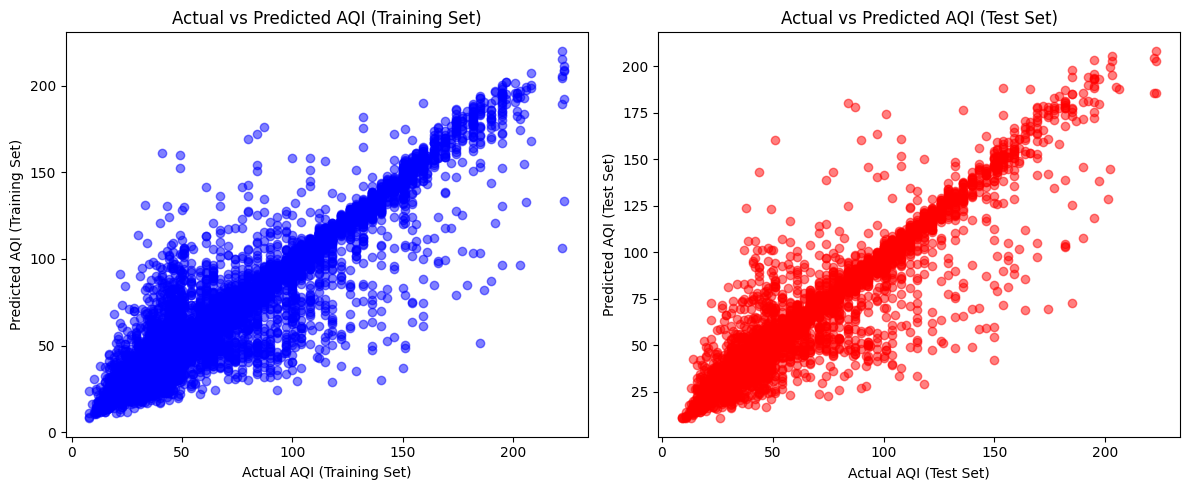

In [ ]:
# Plot actual vs predicted AQI values for the training set
plt.figure(figsize=(12, 5))

# Training Set
plt.subplot(1, 2, 1)
plt.scatter(y_train_rescaled, y_train_pred_rescaled, color='blue', alpha=0.5)
plt.xlabel('Actual AQI (Training Set)')
plt.ylabel('Predicted AQI (Training Set)')
plt.title('Actual vs Predicted AQI (Training Set)')

# Test Set
plt.subplot(1, 2, 2)
plt.scatter(y_test_rescaled, y_pred_rescaled, color='red', alpha=0.5)
plt.xlabel('Actual AQI (Test Set)')
plt.ylabel('Predicted AQI (Test Set)')
plt.title('Actual vs Predicted AQI (Test Set)')

plt.tight_layout()
plt.show()


In [ ]:
# Calculate metrics
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

# Print metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R^2): {r2:.4f}")

Mean Absolute Error (MAE): 3.9419
Mean Squared Error (MSE): 93.7531
Root Mean Squared Error (RMSE): 9.6826
R-squared (R^2): 0.8987
